### Linguistic and structural analysis
 
### Preprocessing

Standard text preprocessing steps were applied to ensure data quality and consistency:

- Tokenization of titles and tags  
- Lowercasing of text  
- Removal of stopwords, special characters, and non-informative tokens  
- Deduplication of near-identical entries  


### NLP Techniques


1. **Part-of-Speech (POS) Tagging**  
  Identifies grammatical roles and recurring syntactic patterns.
  
1. **Dependency Parsing**  
  Examines how **gendered** and **racialized** terms are positioned within phrases, revealing structural relationships.

1. **Bigram and Trigram Modeling**  
  Captures frequently occurring word sequences and stereotypical expressions.



In [1]:
import pandas as pd
from collections import Counter
import src.models.embeddings as embeddings
import src.utils.helpers as helpers
import src.data.clean as clean

import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

/home/olga/Documents/eur-porntypes/stereotype-map/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
columns_to_read = [
    "url",
    "title",
    "categories",
    "date",
    "views",
    "upvotes",
    "downvotes",
    "production",
    "comments",
    "actors",
]

df = pd.read_csv("data/raw/porn-with-dates-2022.csv", usecols=columns_to_read)
df.head(5)

,url,title,categories,date,views,upvotes,downvotes,production,comments,actors
0,https://www.pornhub.com/view_video.php?viewkey...,Cute teen gloryhole handjob,"['Babe', 'Big Tits', 'Brunette', 'HD Porn', 'H...",2018-11-01,37012,78,22,professional,joesenetto 2 months ago In the name of the Rep...,NaN
1,https://www.pornhub.com/view_video.php?viewkey...,Realy Nice Step Mom Angie Gives Titjob Good Yo...,"['Blowjob', 'HD Porn', 'Hardcore', 'MILF', 'Ro...",2018-12-01,2083844,6318,174,professional,AStrayPornCritic 1 month ago Discussion- 2/10T...,NaN
2,https://www.pornhub.com/view_video.php?viewkey...,Step Mom´s gift for son - pov,"['Big Tits', 'Brunette', 'Cumshot', 'HD Porn',...",2018-07-01,22388562,64554,28325,professional,Leopold_Butters 6 months ago You ever had a mo...,"Alex Adams,Shay Evans"
3,https://www.pornhub.com/view_video.php?viewkey...,Baltimore Street Hooker Creampie,"['Amateur', 'Anal', 'Creampie', 'HD Porn', 'Ha...",2018-01-01,348440,1120,124,homemade,MusicSexBliss 1 year ago Nothing hotter that f...,NaN
4,https://www.pornhub.com/view_video.php?viewkey...,Cute Blonde and Brunette Pleasure Each Other,"['Amateur', 'Blonde', 'Brunette', 'Fingering',...",2018-12-01,105513,344,15,professional,deborahedwards947 3 weeks ago Want to see me s...,Alexis Brill


In [15]:
pd.to_datetime(df.date).max()


Timestamp('2018-12-01 00:00:00')

### 1. Tag analysis


##### Frequency and correlation

In [17]:
# Create 'tags' column from categories
df["tags"] = df["categories"].apply(clean.extract_tags)
df = df.drop(columns=["categories"])
# Remove a specific tag from the "tags" column
df["tags"] = df["tags"].apply(clean.remove_tag, tag_to_remove="HD Porn")
# confirm it is a list
# df.tags.apply(lambda tag_list: isinstance(tag_list, list))

In [18]:
# flatten out tags
df_flat_tag = clean.flatten_tags(df.tags)
# number of unique hashtags
df_flat_tag["tag"].unique().size

108

In [19]:
# count the number of each hashtag
popular_tags_set = clean.get_popular_tags(df_flat_tag)

# make a new column with only the popular tags
df["popular_tags"] = df.tags.apply(
    lambda tag_list: clean.filter_popular_tags(tag_list, popular_tags_set)
)
# replace url with identifier
df["url"] = df.url.apply(lambda x: helpers.extract_and_create_unique_id(x, length=11))

# drop rows without popular tag
df_popular_tags = df.loc[df.popular_tags.apply(lambda tag_list: tag_list != [])]
df_tags_vector = df_popular_tags.loc[:, ["popular_tags"]]

for tag in popular_tags_set:
    # make columns to encode presence of hashtags
    df_tags_vector["{}".format(tag)] = df_tags_vector.popular_tags.apply(
        lambda tag_list: int(tag in tag_list)
    )
# create a matrix of tags
tag_matrix = df_tags_vector.drop("popular_tags", axis=1)

In [20]:
tag_matrix.head(5)

,Toys,Blowjob,Big Dick,Blonde,Ebony,Cumshot,Hardcore,Fetish,Reality,Babe,...,Amateur,Verified Amateurs,Teen,POV,Pornstar,Threesome,MILF,Small Tits,Exclusive,Masturbation
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0


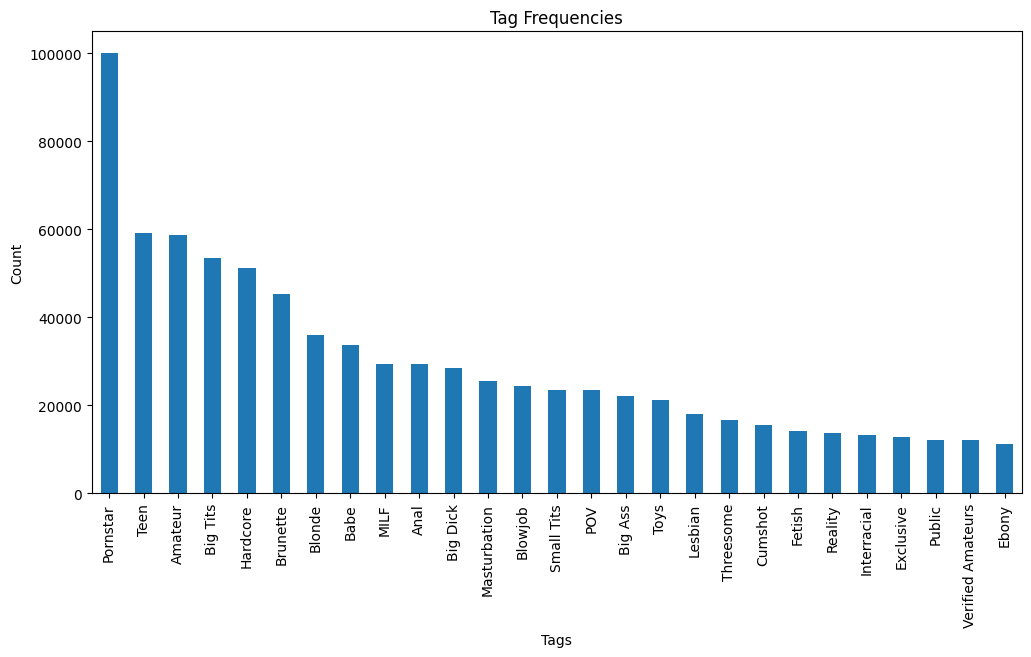

In [21]:
tag_counts = tag_matrix.sum().sort_values(ascending=False)
tag_counts.plot(kind="bar", figsize=(12, 6))
plt.title("Tag Frequencies")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.xticks(rotation=90)
output_plot_path = "plots/tag_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

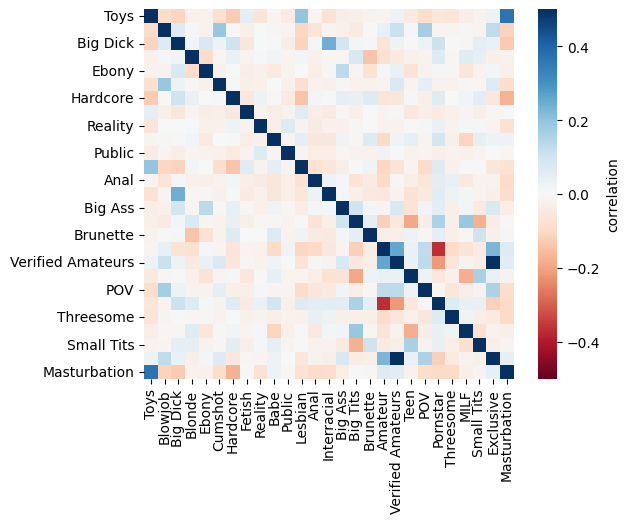

In [22]:
# correlation matrix
correlations = tag_matrix.corr()

sns.heatmap(
    correlations,
    cmap="RdBu",
    vmin=-0.5,
    vmax=0.5,
    square=True,
    cbar_kws={"label": "correlation"},
)
plt.savefig("plots/tag_correlation.png")

In [23]:
# Extract year from date
df["year"] = pd.to_datetime(df["date"]).dt.year

# Explode the popular_tags list so each tag gets its own row
df_exploded = df.explode("popular_tags")

# Group by year and tag, count occurrences
tag_counts = df_exploded.groupby(["year", "popular_tags"]).size().unstack(fill_value=0)

# Normalize counts to get frequencies
tag_frequencies = tag_counts.div(tag_counts.sum(axis=1), axis=0)


In [24]:
tag_frequencies.head(5)

popular_tags,Amateur,Anal,Babe,Big Ass,Big Dick,Big Tits,Blonde,Blowjob,Brunette,Cumshot,...,Masturbation,POV,Pornstar,Public,Reality,Small Tits,Teen,Threesome,Toys,Verified Amateurs
year,,,,,,,,,,,,,,,,,,,,,
2008,0.227119,0.039322,0.015593,0.016271,0.006102,0.058983,0.075932,0.026441,0.082712,0.021017,...,0.065085,0.017627,0.061017,0.018305,0.015593,0.001356,0.025085,0.030508,0.032542,0.000000
2009,0.079969,0.060879,0.024279,0.013943,0.010579,0.086616,0.056096,0.018158,0.060149,0.016091,...,0.036276,0.024927,0.133674,0.009444,0.035141,0.003040,0.053907,0.020266,0.030723,0.000000
2010,0.080613,0.077626,0.005282,0.018906,0.013296,0.096423,0.047137,0.003096,0.079593,0.010127,...,0.043640,0.021856,0.127532,0.013405,0.038759,0.053184,0.055333,0.015700,0.039997,0.000255
2011,0.078073,0.056354,0.016506,0.027279,0.024036,0.061392,0.041179,0.014885,0.040484,0.010599,...,0.031681,0.022819,0.189274,0.021198,0.037472,0.010946,0.079347,0.025773,0.034635,0.000232
2012,0.103738,0.053224,0.027778,0.020610,0.020439,0.067181,0.038992,0.023937,0.035357,0.009156,...,0.026749,0.022188,0.162243,0.020267,0.017044,0.013957,0.087551,0.031310,0.027332,0.000137


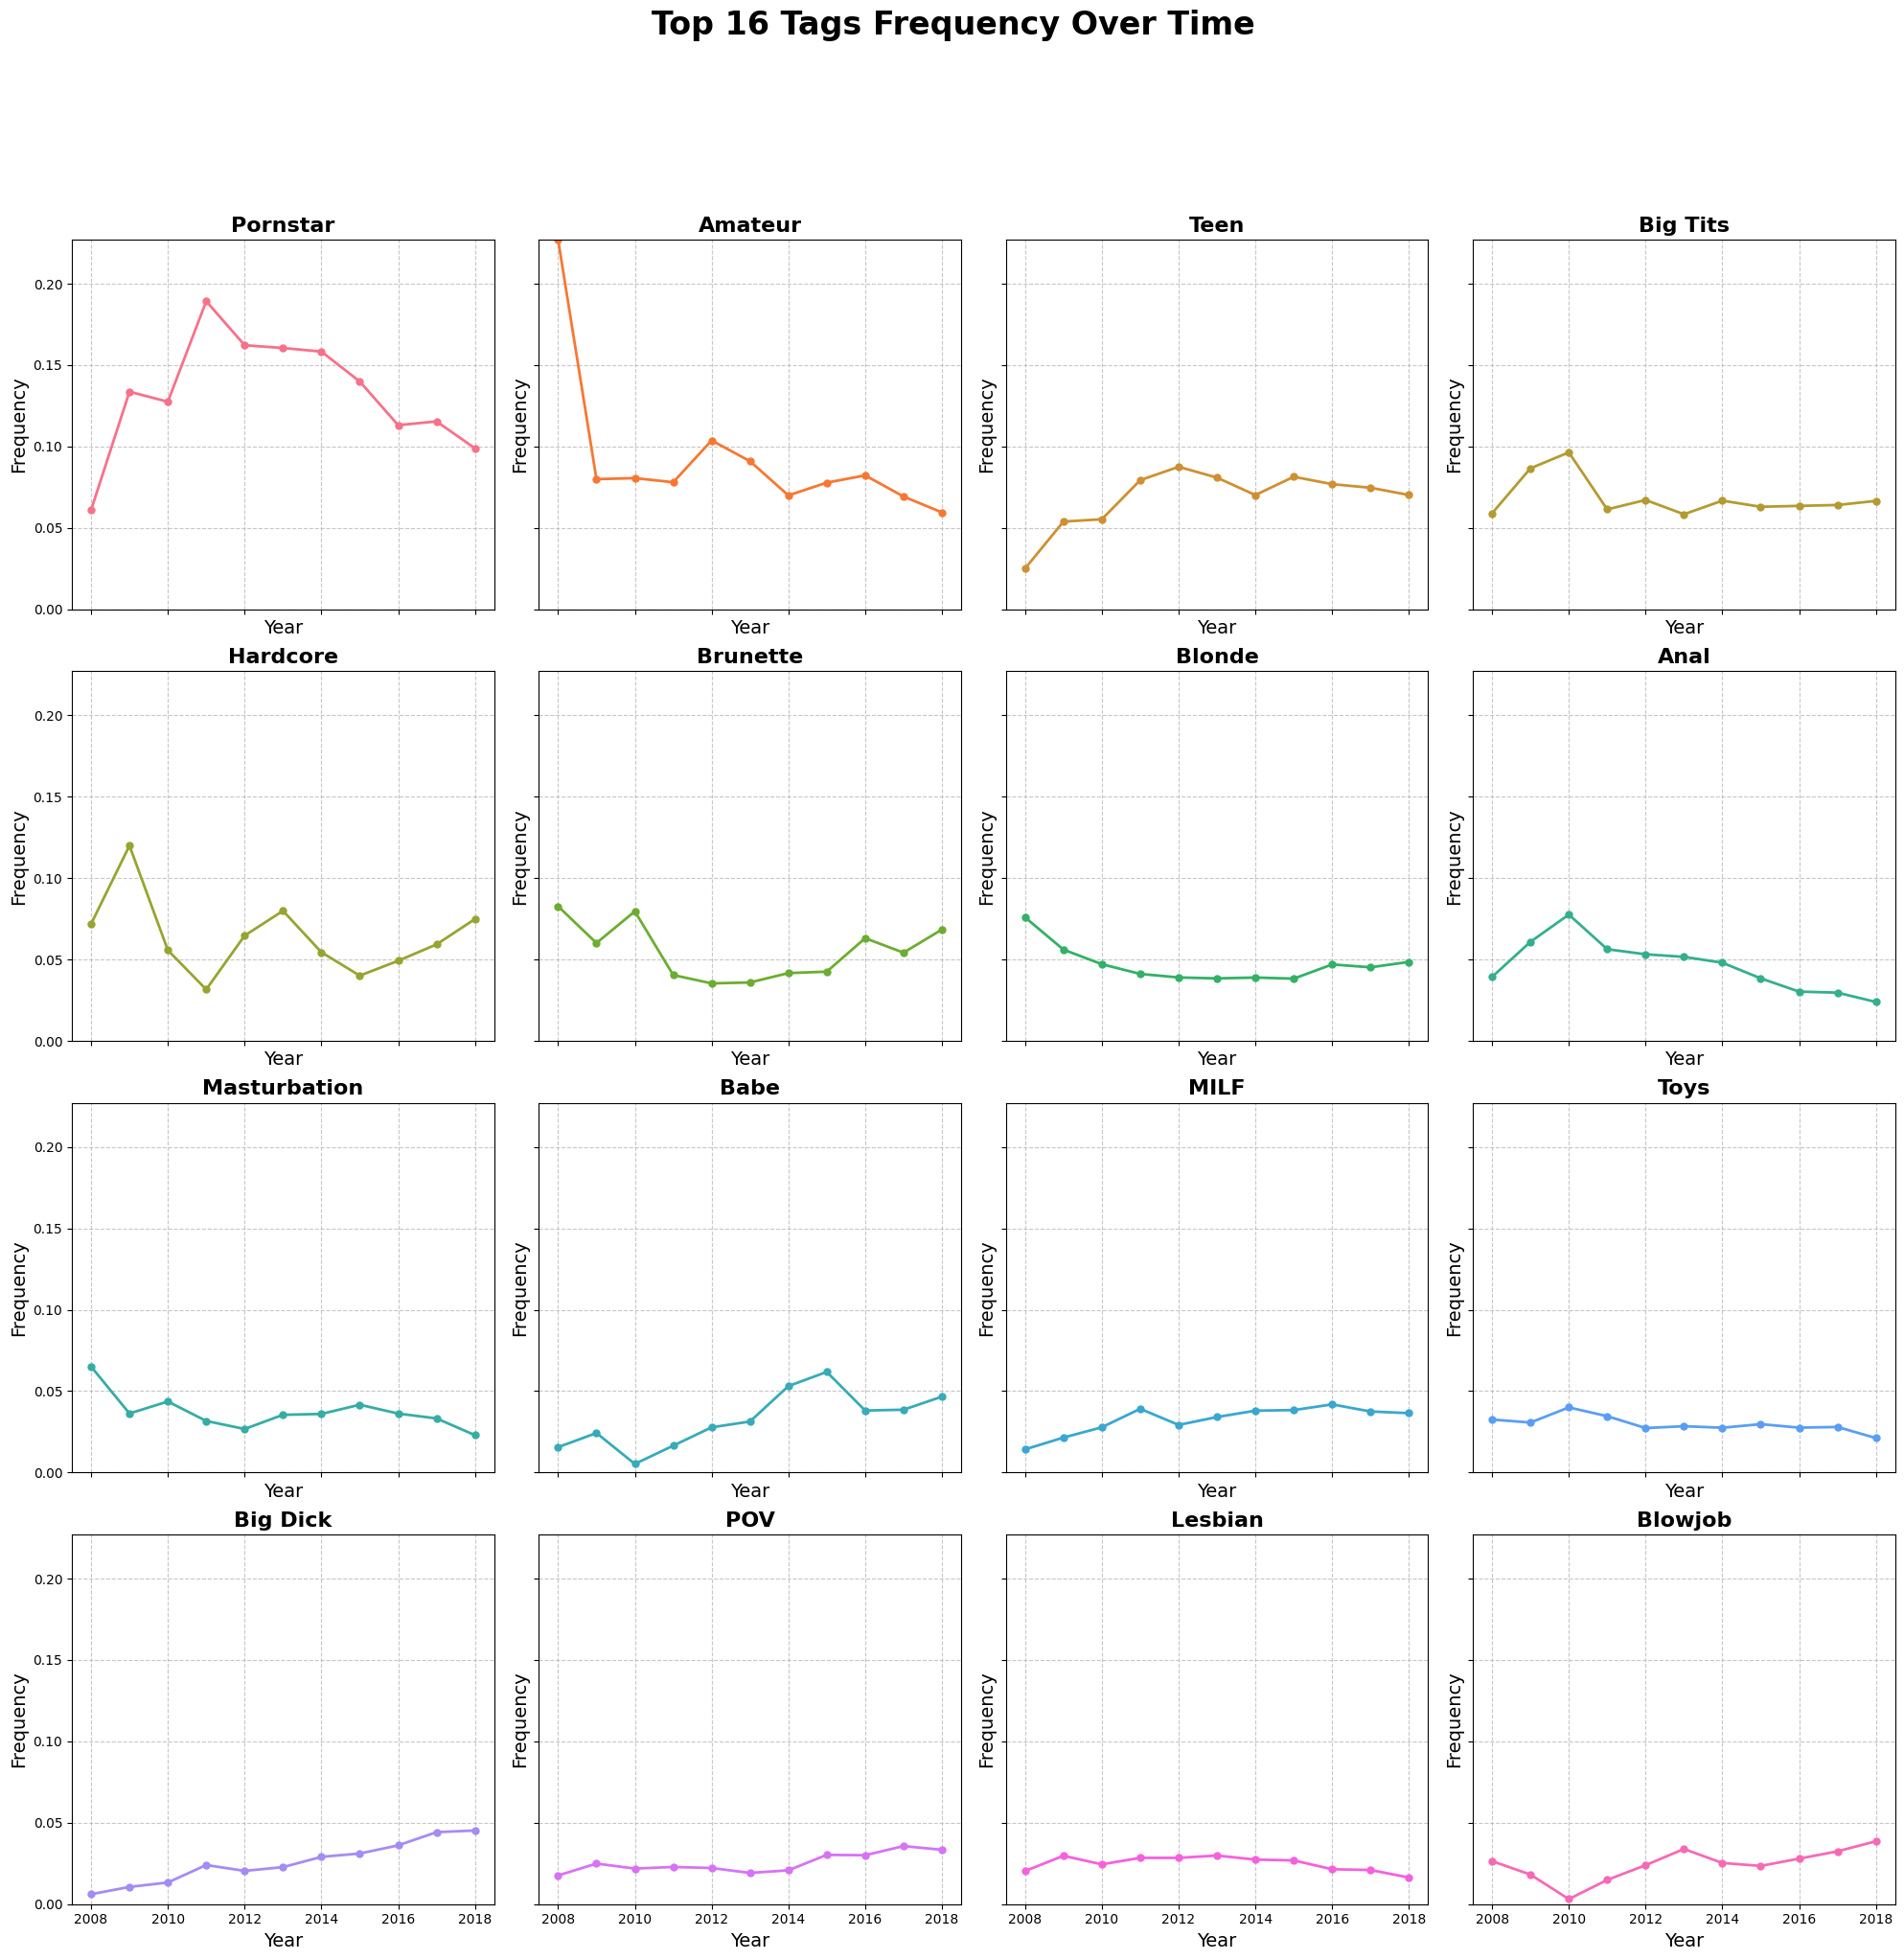

In [25]:
top_tags = tag_frequencies.sum().nlargest(16).index  # Choose top 16 tags
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Set a color palette
colors = sns.color_palette("husl", len(top_tags))

for i, tag in enumerate(top_tags):
    axes[i].plot(
        tag_frequencies.index,
        tag_frequencies[tag],
        color=colors[i],
        linewidth=2,
        marker="o",
        markersize=5,
    )
    axes[i].set_title(tag, fontsize=16, fontweight="bold")
    axes[i].set_ylim(0, tag_frequencies[top_tags].max().max())
    axes[i].set_xlabel("Year", fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    axes[i].grid(
        True, linestyle="--", alpha=0.7
    )  # Add grid lines for better readability

# Adjust layout and aesthetics
plt.suptitle("Top 16 Tags Frequency Over Time", fontsize=24, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
output_plot_path = "plots/top_16_tags_frequency_distribution_time.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

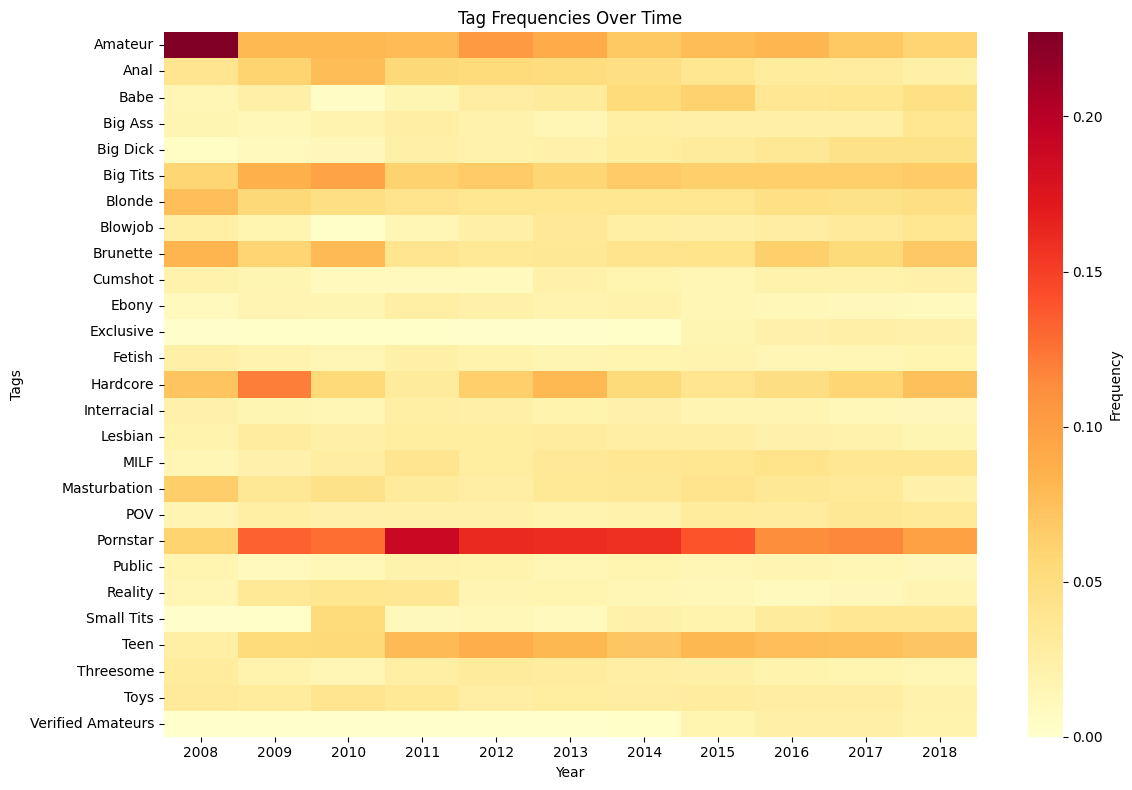

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(tag_frequencies.T, cmap="YlOrRd", cbar_kws={"label": "Frequency"})
plt.title("Tag Frequencies Over Time")
plt.xlabel("Year")
plt.ylabel("Tags")
plt.tight_layout()
output_plot_path = "plots/tag_frequency_time.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

#### POS tagging
POS tagging is a grammatical classification that includes verbs, adjectives, adverbs, nouns, etc.



- What adjectives co-occur with gendered or racial terms?
- Group adjectives that co-occur with gendered or racialised nouns to reveal stereotype patterns?
- Are women-associated tags more likely to include appearance-based adjectives?
- Are men more often subjects of action verbs (agency bias)?


Linguistic bias analysis of adult content metadata

#### Dependency Parsing

#### N-grams

### 2. Title analyses


#### Most common words in titles


In [3]:
from src.models import embeddings

embeddings.download_nltk_data()


# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_tokenize_and_stem)

# Flatten the list of words and count frequencies
all_words = [word for words in df["title_words"] for word in words]
word_counts = Counter(all_words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=["word", "count"])



[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


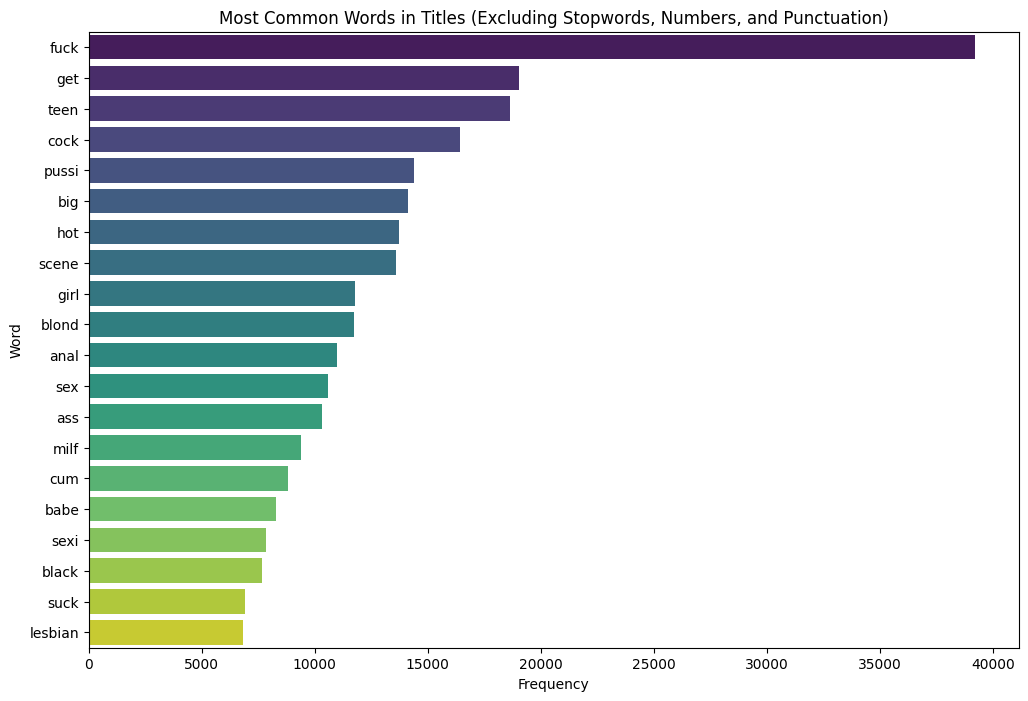

In [4]:
# Plot the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_freq_df, hue="word", palette="viridis")
plt.title("Most Common Words in Titles (Excluding Stopwords, Numbers, and Punctuation)")
plt.xlabel("Frequency")
plt.ylabel("Word")
output_plot_path = "plots/words_titles_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

#### POS tagging

In [5]:
df.columns

Index(['url', 'title', 'categories', 'date', 'views', 'upvotes', 'downvotes',
       'production', 'comments', 'actors', 'title_words'],
      dtype='object')

In [6]:
from src.models.extract_adj_noun_pairs import run_pipeline

# Run pipeline and keep everything
df, pair_df = run_pipeline(df, return_pair_df=True)

# Now df has: title_words + pos_title_with_deps + date etc.
# And pair_df contains frequency counts of adjective–noun pairs


Loading cached POS data...


In [8]:
df.pos_title_with_deps

0         [(cute, ADJ, amod), (teen, NOUN, compound), (g...
1         [(reali, PROPN, amod), (nice, ADJ, amod), (ste...
2         [(step, NOUN, ROOT), (mom, NOUN, compound), (g...
3         [(baltimor, PROPN, compound), (street, PROPN, ...
4         [(cute, ADJ, amod), (blond, PROPN, compound), ...
                                ...                        
217999    [(extrem, PROPN, compound), (gag, NOUN, compou...
218000    [(bad, ADJ, amod), (dragon, NOUN, compound), (...
218001    [(teas, NOUN, ROOT), (best, ADJ, advmod), (fri...
218002    [(watch, VERB, ROOT), (teas, NOUN, compound), ...
218003    [(amateur, PROPN, compound), (lydia, PROPN, co...
Name: pos_title_with_deps, Length: 218004, dtype: object

In [9]:
pair_df

,Pair,Count
107,"(black, cock)",1974
75,"(big, cock)",1923
28,"(big, tit)",1796
37,"(first, time)",1044
281,"(anal, sex)",990
...,...,...
30,"(stepmoth, cure)",1
25348,"(codi, finger)",1
25349,"(hot, sofia)",1
25350,"(latina, melizza)",1


##### What are the most common adjective–noun pairings in titles?

/tmp/ipykernel_417833/2735448853.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")


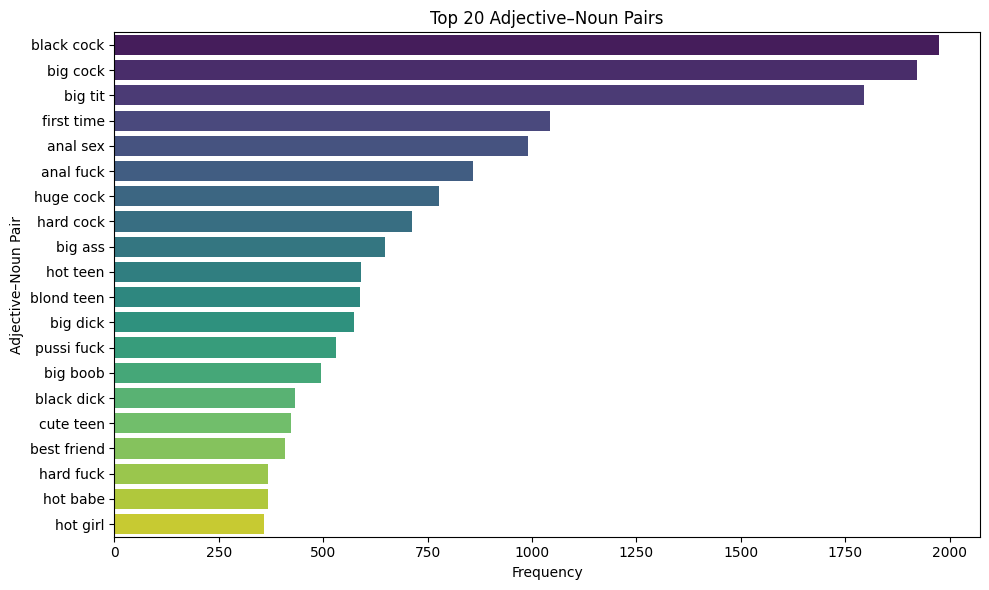

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top N pairs
top_n = 20
top_pairs = pair_df.head(top_n).copy()
top_pairs["pair_str"] = top_pairs["Pair"].apply(lambda x: f"{x[0]} {x[1]}")

plt.figure(figsize=(10, 6))
sns.barplot(data=top_pairs, y="pair_str", x="Count", palette="viridis")
plt.title(f"Top {top_n} Adjective–Noun Pairs")
plt.xlabel("Frequency")
plt.ylabel("Adjective–Noun Pair")
plt.tight_layout()
plt.show()


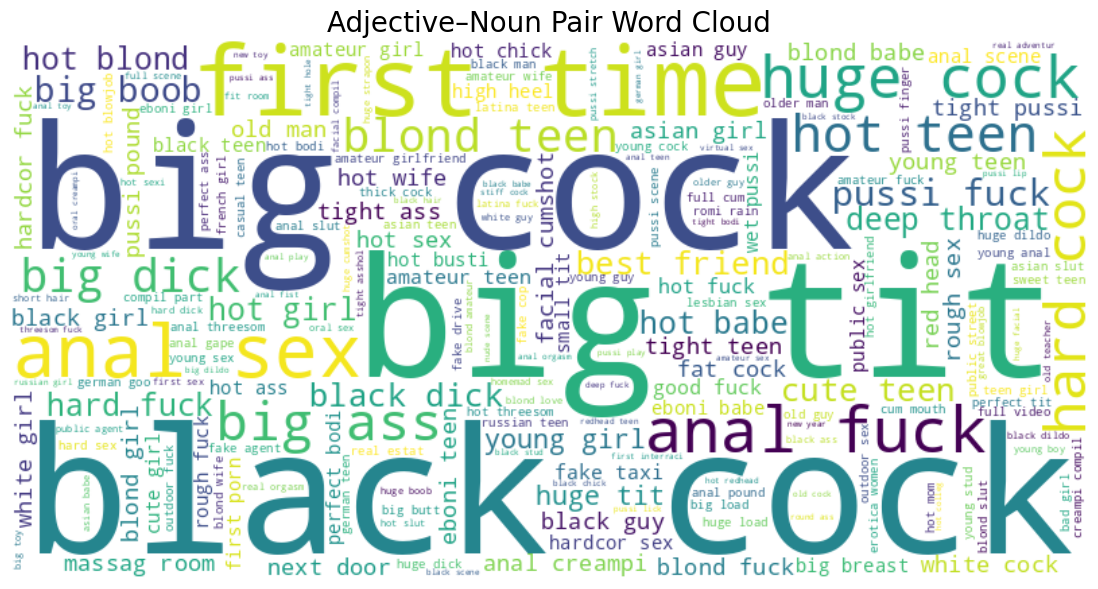

In [11]:
from wordcloud import WordCloud

# Prepare data for word cloud
pair_freq_dict = {f"{adj} {noun}": count for (adj, noun), count in pair_df.head(1000).values}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pair_freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Adjective–Noun Pair Word Cloud", fontsize=20)
plt.show()


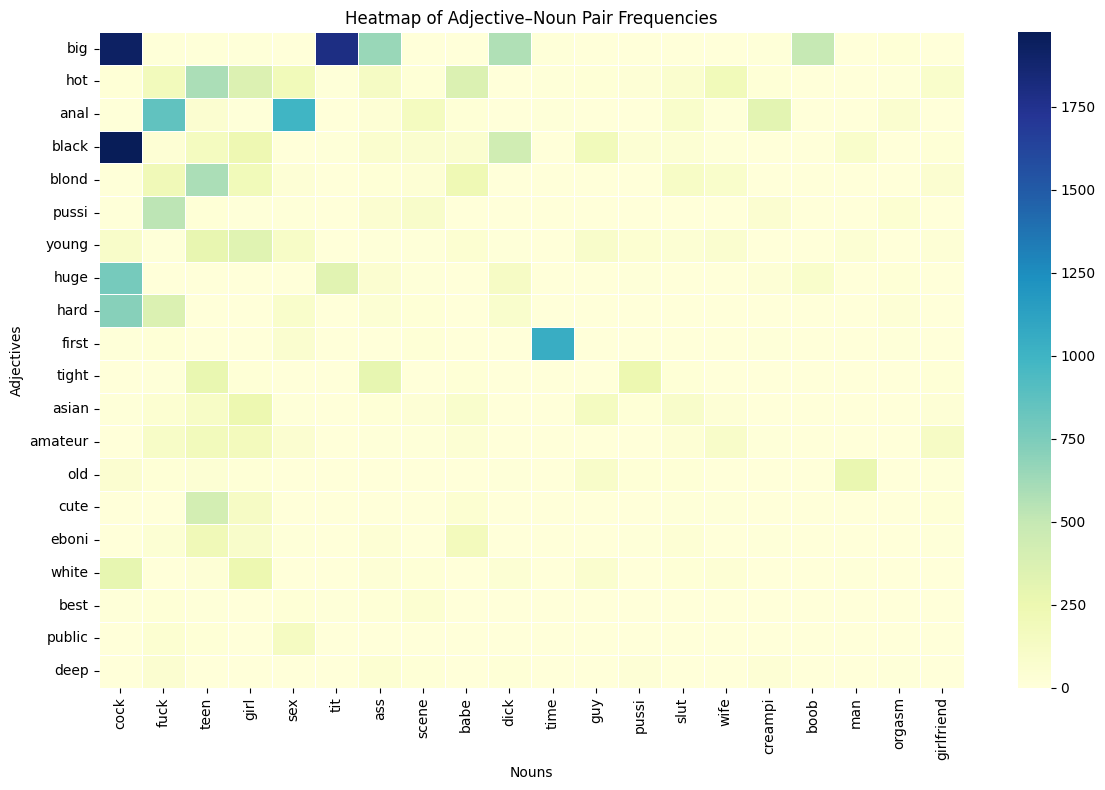

In [12]:
# Create a DataFrame for heatmap: rows = adjectives, cols = nouns
heat_df = pair_df.copy()
heat_df["Adjective"] = heat_df["Pair"].apply(lambda x: x[0])
heat_df["Noun"] = heat_df["Pair"].apply(lambda x: x[1])

pivot = heat_df.pivot_table(index="Adjective", columns="Noun", values="Count", fill_value=0)
pivot_top = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).head(20).index,  # top 20 adjectives
                      pivot.sum().sort_values(ascending=False).head(20).index]        # top 20 nouns

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_top, cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of Adjective–Noun Pair Frequencies")
plt.xlabel("Nouns")
plt.ylabel("Adjectives")
plt.tight_layout()
plt.show()


In [13]:
from src.models.temporal_adj_noun_analysis import extract_temporal_trends

# pairs I want to track
pairs = [("hot", "girl"), ("young", "boy"), ("black", "man"), ("asian", "woman")]
df_ts = extract_temporal_trends(df, pairs)

In [15]:
df_ts

,"(hot, girl)","(young, boy)","(black, man)","(asian, woman)"
2008-01-01,5,0,0,0
2009-01-01,30,0,3,2
2010-01-01,9,0,2,0
2011-01-01,15,3,4,1
2012-01-01,16,0,5,0
2013-01-01,79,15,9,0
2014-01-01,41,16,13,0
2015-01-01,33,15,6,2
2016-01-01,37,8,9,1
2017-01-01,43,3,8,4


/tmp/ipykernel_417833/507446523.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_ts_yearly = df_ts.resample("Y").sum()


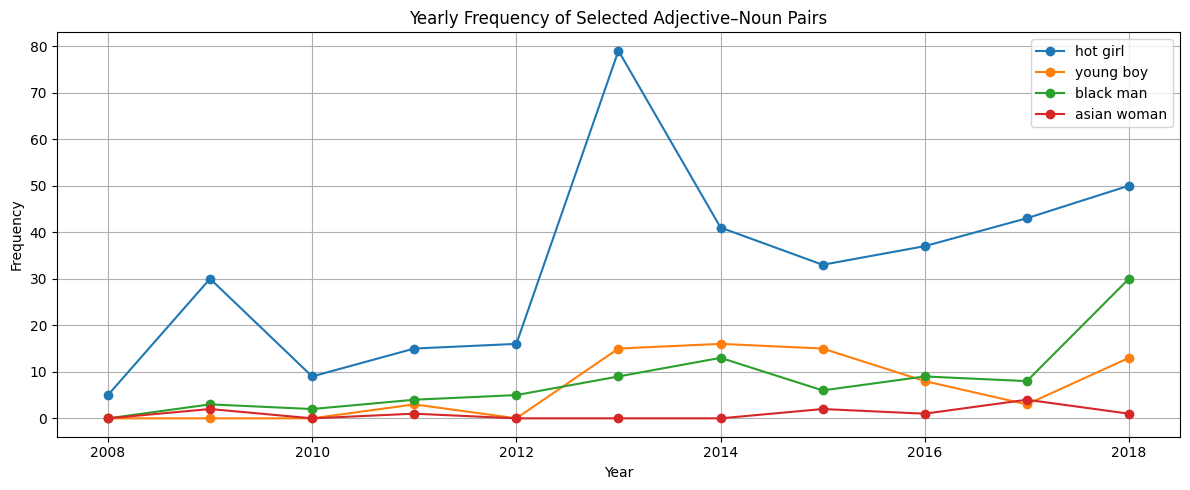

In [18]:
import matplotlib.pyplot as plt
df_ts_yearly = df_ts.resample("Y").sum()

plt.figure(figsize=(12, 5))
for pair in df_ts_yearly.columns:
    plt.plot(df_ts_yearly.index.year, df_ts_yearly[pair], marker="o", label=f"{pair[0]} {pair[1]}")

plt.title("Yearly Frequency of Selected Adjective–Noun Pairs")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [50]:
# Are certain adjectives disproportionately used with gendered or racialized nouns?
from collections import Counter
import pandas as pd

# Define gendered and racialized nouns
gendered_nouns = {"man", "woman", "girl", "boy", "male", "female"}
racialized_nouns = {"black", "white", "asian", "latina", "latino"}

# Ensure that rows in df.pos_title are valid lists of tuples
valid_rows = df.pos_title.dropna()  # Remove NaN values
valid_rows = valid_rows[valid_rows.apply(lambda x: isinstance(x, list))]  # Keep only lists

# Extract adjective–noun pairs for gendered and racialized nouns
adj_noun_pairs = [
    (word, next_word)
    for row in valid_rows  # Iterate through each valid row in the pos_title column
    for (word, tag), (next_word, next_tag) in zip(row, row[1:])  # Pair consecutive tokens
    if tag == "ADJ" and next_tag == "NOUN" and next_word.lower() in gendered_nouns.union(racialized_nouns)
]

# Count the frequency of adjectives for each noun
adj_counts = Counter([(adj, noun) for adj, noun in adj_noun_pairs])

# Convert to a DataFrame for analysis
adj_noun_df = pd.DataFrame(adj_counts.items(), columns=["Pair", "Count"])
adj_noun_df[["Adjective", "Noun"]] = pd.DataFrame(adj_noun_df["Pair"].tolist(), index=adj_noun_df.index)
adj_noun_df = adj_noun_df.drop(columns=["Pair"]).sort_values(by="Count", ascending=False)

# Separate data for gendered and racialized nouns
gendered_df = adj_noun_df[adj_noun_df["Noun"].isin(gendered_nouns)]
racialized_df = adj_noun_df[adj_noun_df["Noun"].isin(racialized_nouns)]

# Display the top adjectives for gendered and racialized nouns
print("Top Adjectives for Gendered Nouns:")
print(gendered_df.head(10))

print("\nTop Adjectives for Racialized Nouns:")
print(racialized_df.head(10))

Top Adjectives for Gendered Nouns:
   Count Adjective  Noun
0      1    skater  girl

Top Adjectives for Racialized Nouns:
Empty DataFrame
Columns: [Count, Adjective, Noun]
Index: []


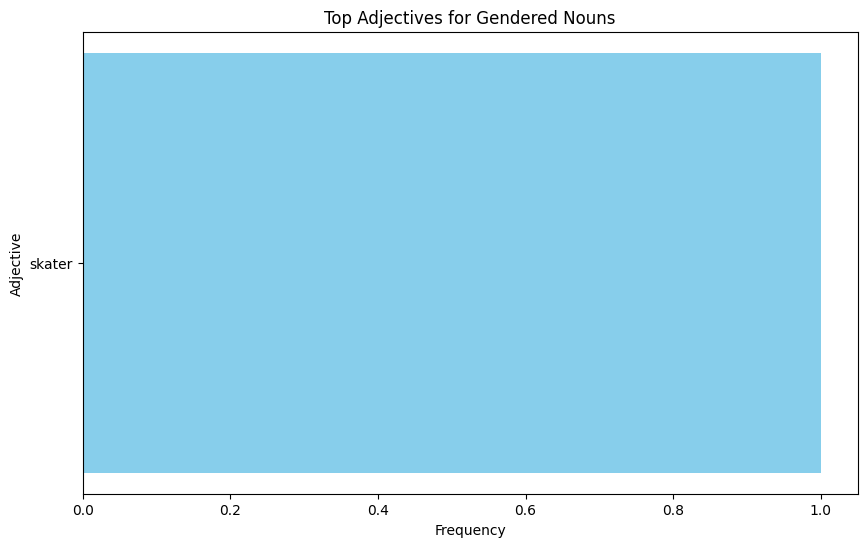

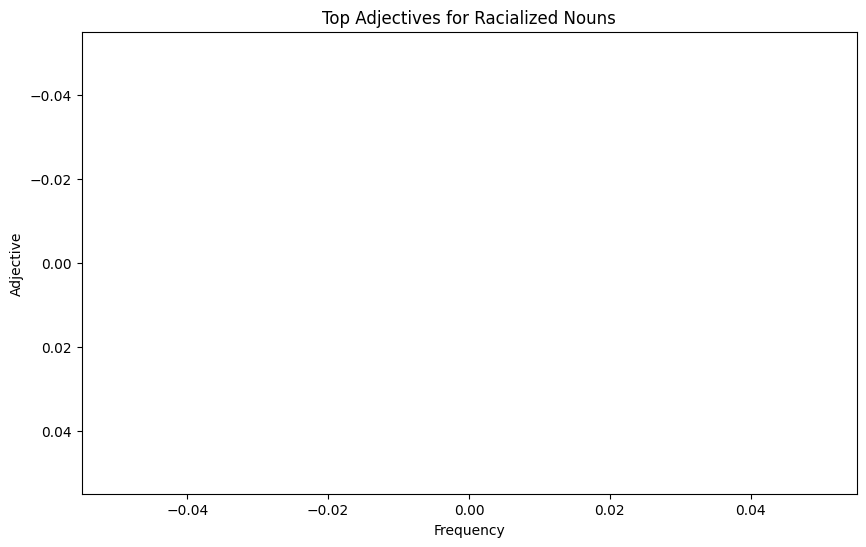

In [51]:
import matplotlib.pyplot as plt

# Plot top adjectives for gendered nouns
top_gendered = gendered_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_gendered["Adjective"], top_gendered["Count"], color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Adjective")
plt.title("Top Adjectives for Gendered Nouns")
plt.gca().invert_yaxis()
plt.show()

# Plot top adjectives for racialized nouns
top_racialized = racialized_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_racialized["Adjective"], top_racialized["Count"], color="lightcoral")
plt.xlabel("Frequency")
plt.ylabel("Adjective")
plt.title("Top Adjectives for Racialized Nouns")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Do descriptions of female performers rely more heavily on adjectives (e.g., appearance) than 
# descriptions of male performers (e.g., roles or actions)?
from collections import Counter
import pandas as pd

# Define gendered nouns
female_nouns = {"woman", "girl", "female"}
male_nouns = {"man", "boy", "male"}

# Define appearance-based adjectives (example list, expand as needed)
appearance_adjectives = {"beautiful", "cute", "pretty", "sexy", "attractive", "gorgeous", "hot"}
action_adjectives = {"strong", "dominant", "brave", "powerful", "confident", "aggressive"}

# Ensure that rows in df.pos_title are valid lists of tuples
valid_rows = df.pos_title.dropna()  # Remove NaN values
valid_rows = valid_rows[valid_rows.apply(lambda x: isinstance(x, list))]  # Keep only lists

# Extract adjective–noun pairs for gendered nouns
adj_noun_pairs = [
    (word, next_word)
    for row in valid_rows  # Iterate through each valid row in the pos_title column
    for (word, tag), (next_word, next_tag) in zip(row, row[1:])  # Pair consecutive tokens
    if tag == "ADJ" and next_tag == "NOUN" and next_word.lower() in female_nouns.union(male_nouns)
]

# Count the frequency of adjectives for female and male nouns
female_adj_counts = Counter([adj for adj, noun in adj_noun_pairs if noun in female_nouns])
male_adj_counts = Counter([adj for adj, noun in adj_noun_pairs if noun in male_nouns])

# Filter for appearance-based adjectives
female_appearance_counts = {adj: count for adj, count in female_adj_counts.items() if adj in appearance_adjectives}
male_appearance_counts = {adj: count for adj, count in male_adj_counts.items() if adj in appearance_adjectives}

# Convert to DataFrames for visualization
female_df = pd.DataFrame(female_appearance_counts.items(), columns=["Adjective", "Count"]).sort_values(by="Count", ascending=False)
male_df = pd.DataFrame(male_appearance_counts.items(), columns=["Adjective", "Count"]).sort_values(by="Count", ascending=False)

# Display the top appearance-based adjectives for female and male nouns
print("Top Appearance-Based Adjectives for Female Nouns:")
print(female_df.head(10))

print("\nTop Appearance-Based Adjectives for Male Nouns:")
print(male_df.head(10))

Top Appearance-Based Adjectives for Female Nouns:
Empty DataFrame
Columns: [Adjective, Count]
Index: []

Top Appearance-Based Adjectives for Male Nouns:
Empty DataFrame
Columns: [Adjective, Count]
Index: []


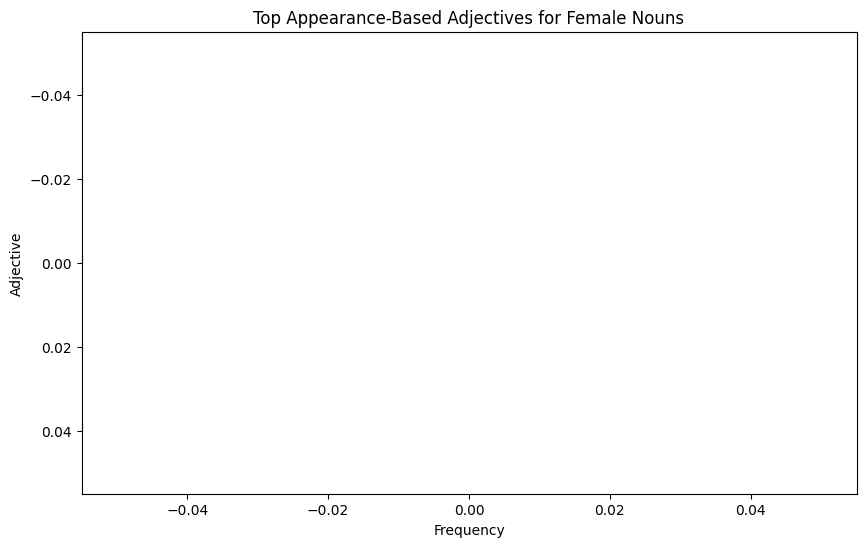

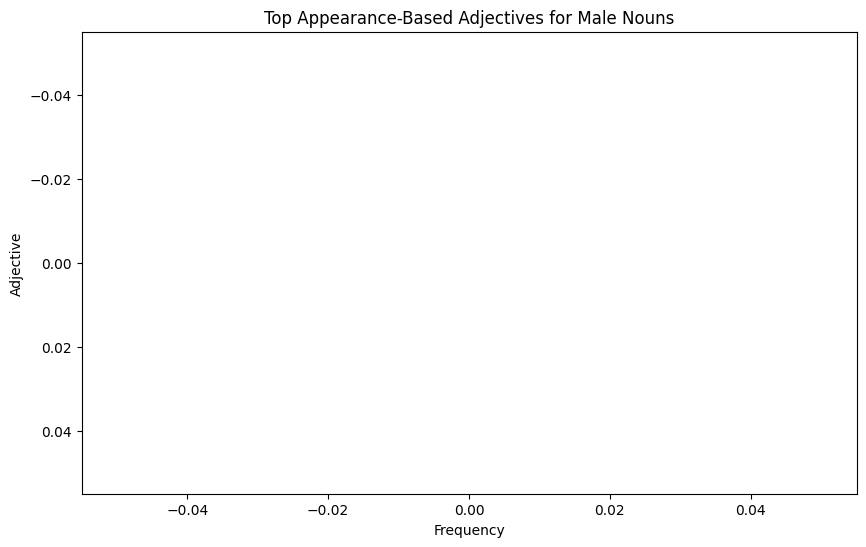

In [53]:
import matplotlib.pyplot as plt

# Plot top appearance-based adjectives for female nouns
plt.figure(figsize=(10, 6))
plt.barh(female_df["Adjective"], female_df["Count"], color="pink")
plt.xlabel("Frequency")
plt.ylabel("Adjective")
plt.title("Top Appearance-Based Adjectives for Female Nouns")
plt.gca().invert_yaxis()
plt.show()

# Plot top appearance-based adjectives for male nouns
plt.figure(figsize=(10, 6))
plt.barh(male_df["Adjective"], male_df["Count"], color="blue")
plt.xlabel("Frequency")
plt.ylabel("Adjective")
plt.title("Top Appearance-Based Adjectives for Male Nouns")
plt.gca().invert_yaxis()
plt.show()

In [58]:
# Is there a difference in the grammatical framing of subjects and objects across gender categories (e.g., who acts vs. who is acted upon)?
# Add dependency info to the pos_title column
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to add dependency information
def add_dependencies(row):
    if isinstance(row, list):  # Ensure the row is a list of words
        text = " ".join([word for word, _ in row])  # Join words into a sentence
        doc = nlp(text)  # Process the sentence with spaCy
        return [(token.text, token.pos_, token.dep_) for token in doc]  # Return (word, POS, dependency)
    return None

# Apply the function to the pos_title column
df["pos_title_with_deps"] = df.pos_title.apply(add_dependencies)

In [59]:
from collections import Counter
import pandas as pd

# Define gendered nouns
female_nouns = {"woman", "girl", "female"}
male_nouns = {"man", "boy", "male"}

# Ensure that rows in df.pos_title_with_deps are valid lists of tuples
valid_rows = df.pos_title_with_deps.dropna()  # Remove NaN values
valid_rows = valid_rows[valid_rows.apply(lambda x: isinstance(x, list))]  # Keep only lists

# Extract subjects and objects for gendered nouns
subjects = []
objects = []

for row in valid_rows:
    for word, pos, dep in row:  # Each tuple is (word, POS, dependency)
        if word.lower() in female_nouns.union(male_nouns):
            if dep == "nsubj":  # Subject
                subjects.append(word.lower())
            elif dep in {"dobj", "pobj"}:  # Object
                objects.append(word.lower())

# Count frequencies for subjects and objects
subject_counts = Counter(subjects)
object_counts = Counter(objects)

# Separate counts for female and male nouns
female_subjects = sum(subject_counts[noun] for noun in female_nouns)
male_subjects = sum(subject_counts[noun] for noun in male_nouns)

female_objects = sum(object_counts[noun] for noun in female_nouns)
male_objects = sum(object_counts[noun] for noun in male_nouns)

# Create a DataFrame for visualization
data = {
    "Category": ["Female", "Male"],
    "Subjects": [female_subjects, male_subjects],
    "Objects": [female_objects, male_objects],
}
df_roles = pd.DataFrame(data)

# Display the DataFrame
print(df_roles)

  Category  Subjects  Objects
0   Female         2        1
1     Male         1        1


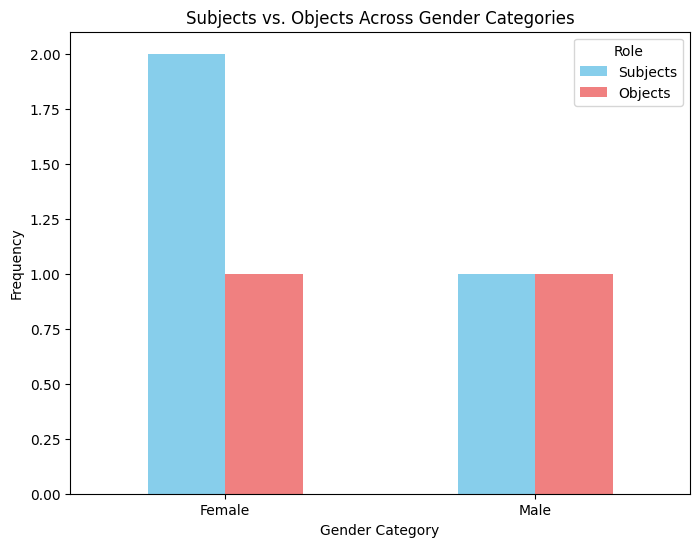

In [60]:
import matplotlib.pyplot as plt

# Plot subjects vs. objects for gender categories
df_roles.set_index("Category").plot(kind="bar", figsize=(8, 6), color=["skyblue", "lightcoral"])
plt.xlabel("Gender Category")
plt.ylabel("Frequency")
plt.title("Subjects vs. Objects Across Gender Categories")
plt.xticks(rotation=0)
plt.legend(title="Role")
plt.show()

#### Sentiment analysis


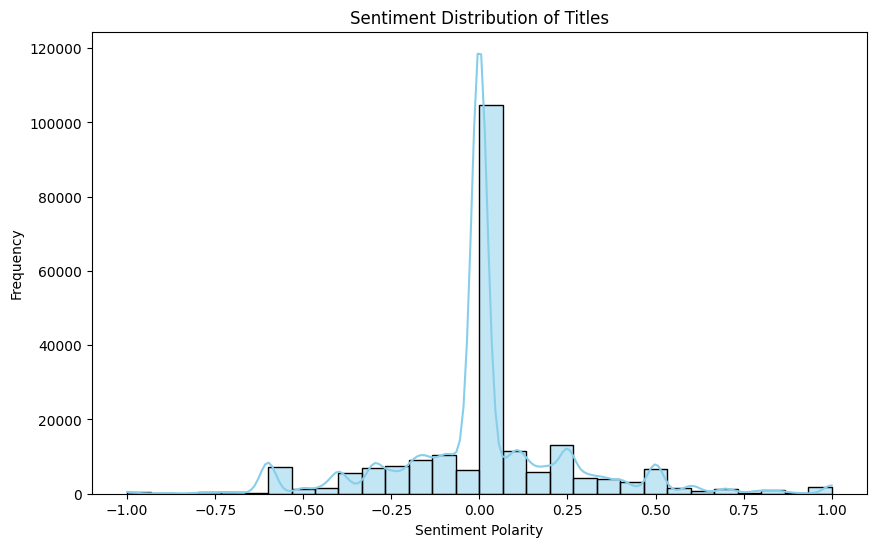

In [29]:
from textblob import TextBlob


# Function to calculate sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


# Apply the function to the title column
df["sentiment"] = df["title"].apply(get_sentiment)

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df["sentiment"], bins=30, kde=True, color="skyblue")
plt.title("Sentiment Distribution of Titles")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
output_plot_path = "plots/title_sentiment_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

# # Print some example titles with their sentiment scores
# print(df[["title", "sentiment"]].head(10))

#### N-grams 
Identify most common adjacent pairs 

Identify pairs of adjacent words in titles and see which are more prevalent in the dataset. N-grams capture more context than unigrams (single words) allowing for a better understandig of the relationship between words. They also allow to identify collocations (words that frequently appear together).


[nltk_data] Downloading package stopwords to /home/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


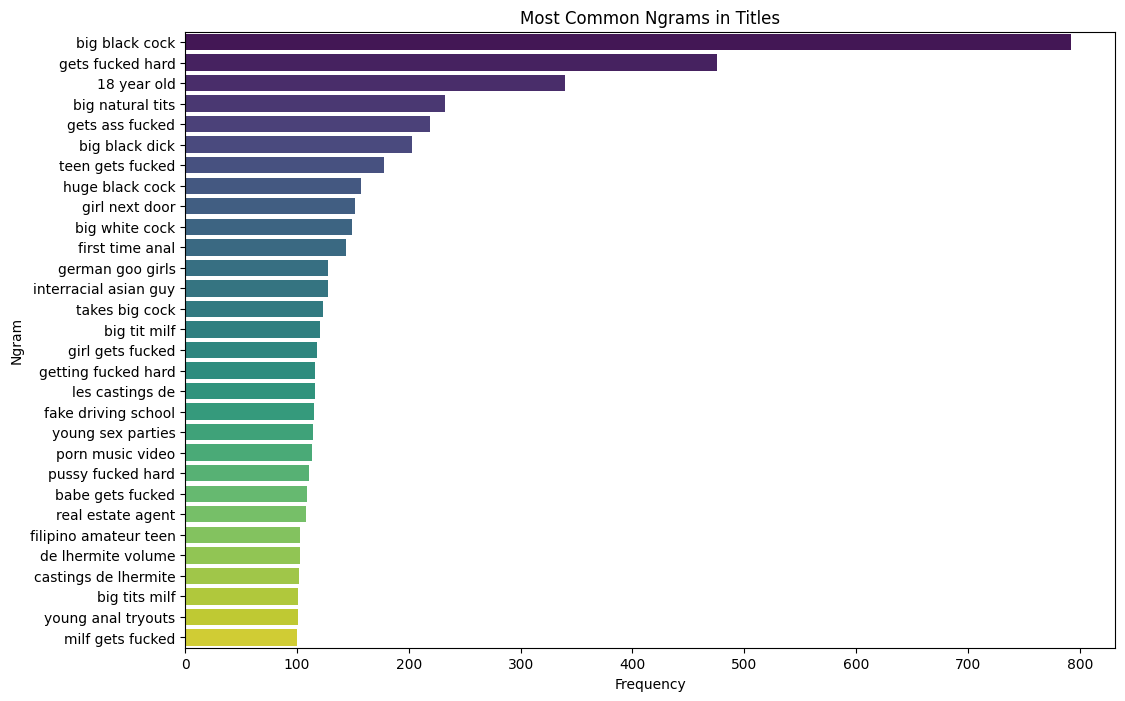

In [8]:
from nltk.util import ngrams
from src.models import embeddings

embeddings.download_nltk_data()

# Apply the function to the title column
df["title_words"] = df["title"].apply(embeddings.clean_and_tokenize)

# Generate bigrams
all_ngrams = [ngram for words in df["title_words"] for ngram in ngrams(words, 3)]

# Count the frequency of each bigram
ngram_counts = Counter(all_ngrams)

# Get the most common bigrams
most_common_ngrams = ngram_counts.most_common(30)

# Convert to DataFrame for plotting, converting bigrams to strings
ngram_freq_df = pd.DataFrame(most_common_ngrams, columns=["ngram", "count"])
ngram_freq_df["ngram"] = ngram_freq_df["ngram"].apply(lambda x: " ".join(x))

# Plot the most common bigrams
plt.figure(figsize=(12, 8))
sns.barplot(
    x="count",
    y="ngram",
    data=ngram_freq_df,
    hue="ngram",
    palette="viridis",
    legend=False,
)
plt.title("Most Common Ngrams in Titles")
plt.xlabel("Frequency")
plt.ylabel("Ngram")
output_plot_path = "plots/most_common_ngrams_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()

In [ ]:
df.sentiment

0         0.250000
1         0.466667
2         0.000000
3         0.000000
4         0.125000
            ...   
217999   -0.362500
218000   -0.700000
218001    1.000000
218002   -0.500000
218003   -0.250000
Name: sentiment, Length: 218004, dtype: float64

In [11]:
# here
df.columns

Index(['url', 'title', 'date', 'views', 'upvotes', 'downvotes', 'production',
       'comments', 'actors', 'tags', 'popular_tags', 'year', 'title_words'],
      dtype='object')

### 3. Grammatical analysis

- Indirect objects
- Active and passive subject, person or not e.g. body part
- adjective + subject What adjectives are more frequent with subjects e.g. hot chinese girl, and frequency distribution of adjectives and subjects
- context, place - in the shower, in the room, etc
- verbs frequency


In [ ]:
import spacy
# python -m spacy download en_core_web_sm
# Load the English NLP model
nlp = spacy.load("en_core_web_md")

# # TODO need more thinking
# # Function to extract indirect objects from a title
# def extract_indirect_object(title):
#     doc = nlp(title)
#     indirect_objects = []

#     for token in doc:
#         # Check for indirect object (dative case) or preposition followed by a noun
#         if token.dep_ == "iobj":
#             indirect_objects.append(token.text)
#         elif token.dep_ == "prep":  # Check for prepositions
#             # Look for the object of the preposition
#             for child in token.children:
#                 if child.dep_ in [
#                     "pobj",
#                     "dobj",
#                 ]:  # Object of the preposition or direct object
#                     indirect_objects.append(child.text)

#     return indirect_objects


# # Apply the function to the titles in the DataFrame
# df["indirect_object"] = df["title"].apply(extract_indirect_object)

# # Display the results
# df[["title", "indirect_object"]]


OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# Subject active

import spacy
# python -m spacy download en_core_web_sm
# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# subset the data
df = df.head(1000)

# Function to extract active subjects from a sentence
def extract_active_subjects(sentence):
    doc = nlp(sentence)
    subjects = []

    for token in doc:
        # Check for nominal subjects (nsubj) and compound subjects
        if token.dep_ == "nsubj":
            subjects.append(token.text)
        # Check for compound subjects
        elif token.dep_ == "nsubj" and token.head.dep_ == "ROOT":
            for child in token.children:
                if child.dep_ == "conj":  # Check for conjunctions
                    subjects.append(child.text)

    # Remove duplicates and return
    return list(set(subjects))

# Apply the function to the titles in the DataFrame
df["subject_active"] = df["title"].apply(extract_active_subjects)


In [15]:
# Function to extract passive subjects from a sentence
def extract_passive_subjects(sentence):
    doc = nlp(sentence)
    passive_subjects = []

    for token in doc:
        # Check if the token is a passive subject
        if token.dep_ == "nsubjpass":
            passive_subjects.append(token.text)
        # Additionally, check for auxiliary verbs that indicate passive voice
        elif token.dep_ == "auxpass":  # Auxiliary verb for passive voice
            # Check if the head of the auxiliary verb is a verb in passive form
            if token.head.dep_ == "VERB" and token.head.tag_ in [
                "VBN",
                "VBD",
            ]:  # VBN: past participle, VBD: past tense
                # Get the subject of the passive construction
                for child in token.head.children:
                    if child.dep_ == "nsubjpass":
                        passive_subjects.append(child.text)

    return passive_subjects


# Apply the function to the titles in the DataFrame
df["subject_pass"] = df["title"].apply(extract_passive_subjects)


In [ ]:
# df[["title", "subject_active", "subject_pass"]].sample(50)


In [16]:
# Flatten the list of active subjects and lemmatize while normalizing case
all_active_subjects = []
for sublist in df["subject_active"]:
    for subject in sublist:
        doc = nlp(subject)  # Tokenize and lemmatize
        lemmatized_subjects = [
            token.lemma_.lower() for token in doc
        ]  # Get the lemmatized form and convert to lowercase
        all_active_subjects.extend(
            lemmatized_subjects
        )  # Add lemmatized subjects to the list

# Count the frequency of each subject
subject_frequency = Counter(all_active_subjects)

# Convert the frequency counts to a DataFrame
frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

# Sort the DataFrame by frequency in descending order
frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# Save the frequency DataFrame to a CSV file
output_csv_path = "data/processed/active_subject_frequency_distribution.csv"
frequency_df.to_csv(output_csv_path, index=False)


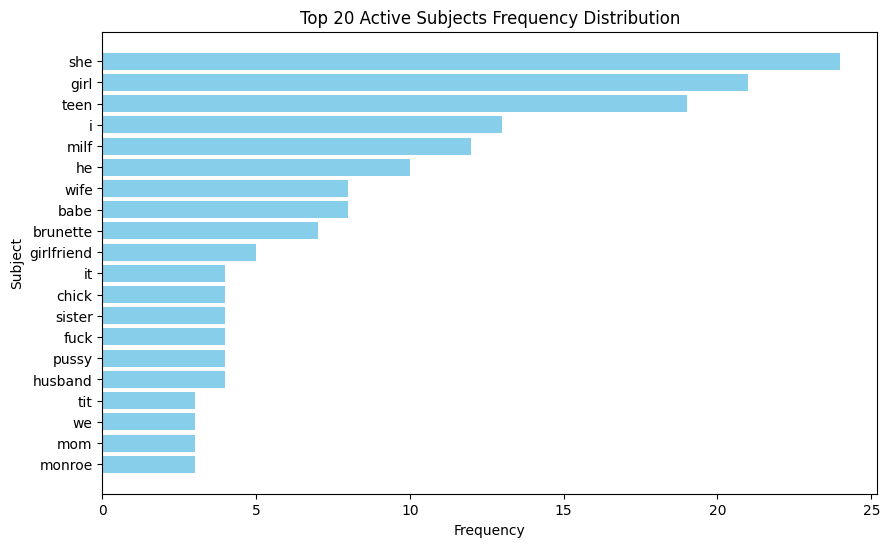

In [17]:
# Create a bar chart for the top N subjects
top_n = 20  # Change this to the number of top subjects you want to visualize
plt.figure(figsize=(10, 6))
plt.barh(
    frequency_df["Subject"].head(top_n),
    frequency_df["Frequency"].head(top_n),
    color="skyblue",
)
plt.xlabel("Frequency")
plt.ylabel("Subject")
plt.title(f"Top {top_n} Active Subjects Frequency Distribution")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
output_plot_path = "plots/top_active_subjects_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")
plt.show()


In [18]:
# Flatten the list of passive subjects and lemmatize while normalizing case
all_passive_subjects = []
for sublist in df["subject_pass"]:
    for subject in sublist:
        doc = nlp(subject)  # Tokenize and lemmatize
        lemmatized_subjects = [token.lemma_.lower() for token in doc]
        all_passive_subjects.extend(lemmatized_subjects)

subject_frequency = Counter(all_passive_subjects)

frequency_df = pd.DataFrame(subject_frequency.items(), columns=["Subject", "Frequency"])

frequency_df = frequency_df.sort_values(by="Frequency", ascending=False)

# Save the frequency DataFrame to a CSV file
output_csv_path = "data/processed/passive_subject_frequency_distribution.csv"
frequency_df.to_csv(output_csv_path, index=False)


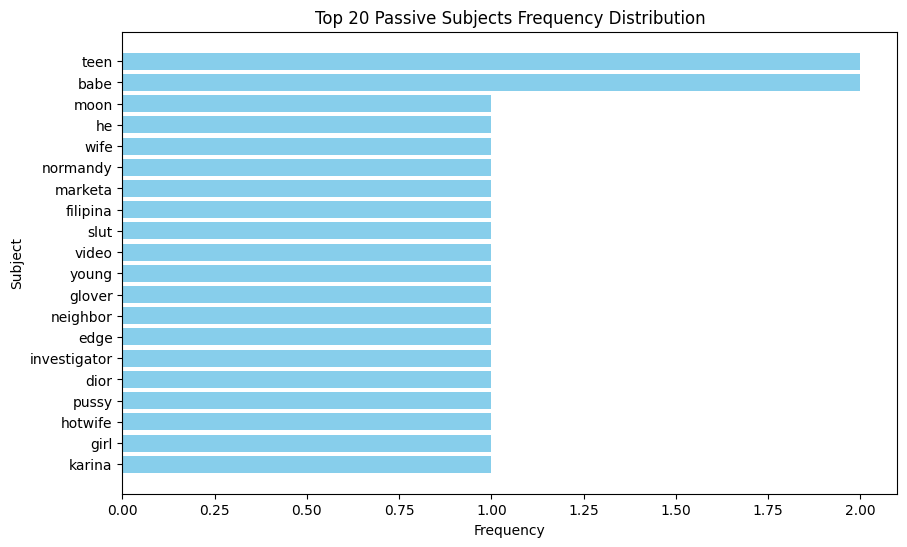

In [19]:
# Create a bar chart for the top N subjects
top_n = 20

plt.figure(figsize=(10, 6))
plt.barh(
    frequency_df["Subject"].head(top_n),
    frequency_df["Frequency"].head(top_n),
    color="skyblue",
)
plt.xlabel("Frequency")
plt.ylabel("Subject")
plt.title(f"Top {top_n} Passive Subjects Frequency Distribution")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
output_plot_path = "plots/top_passive_subjects_frequency_distribution.png"
plt.savefig(output_plot_path, bbox_inches="tight")  # Save the figure with tight layout
plt.show()


In [ ]:
#### Context (in the room, on the chair etc)

In [ ]:
#### Adjective (freq distribution) + Subject, which adjectives are more frequent with subjects

In [ ]:
#### Verbs

In [ ]:
# save data to processed
# first 1000 lines
output_path = "data/processed/dat1000.csv"
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")


DataFrame saved to data/processed/dat1000.csv
